### Imports

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# CONSTANTS
G = 6.67430e-11  # SI units
AU = 1.496e11    # astronomical unit in meters
Mo = 1.989e30    # solar mass in kg

Using device: cuda


### Data Generation Functions

In [7]:
def two_body_ode(t, y, m1, m2, G):
    x1 = y[0:2]
    x2 = y[2:4]
    v1 = y[4:6]
    v2 = y[6:8]
    r = x2 - x1
    dist = np.linalg.norm(r)

    # Safe guard against division by 0
    if dist < 1e-5:
        force_dir = np.zeros_like(r)
        dist = 1e-5
    else:
        force_dir = r / dist

    F = G * m1 * m2 / dist**2
    a1 = F * force_dir / m1
    a2 = -F * force_dir / m2

    return np.concatenate([v1, v2, a1, a2])

def datagen(m1, m2, x1, x2, v1, v2, n_days):
    y0 = np.concatenate([x1, x2, v1, v2])
    t_span = (0, n_days * 24 * 3600)
    t_eval = np.linspace(*t_span, 5000)
    sol = solve_ivp(two_body_ode, t_span, y0, t_eval=t_eval, args=(m1, m2, G), method='RK45', rtol=1e-8, atol=1e-10)

    X_data = sol.t.reshape(-1, 1) # shape: (n_days,1)
    Y_x1 = sol.y[0:2, :].T
    Y_x2 = sol.y[2:4, :].T
    # Y_v1 = sol.y[4:6, :].T
    # Y_v2 = sol.y[6:8, :].T
    Y_data = np.hstack([Y_x1, Y_x2])
    return X_data, Y_data

### PINN Model

In [8]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        return self.net(x)

### Loss Calculation Functions

In [9]:
def L_phy(model, t, m1, m2, y_min, y_max):
    t.requires_grad_(True)
    pred = model(t)
    x1 = pred[:, 0:2]
    x2 = pred[:, 2:4]

    x1_phys = x1 * (y_max[0:2] - y_min[0:2]) + y_min[0:2]
    x2_phys = x2 * (y_max[2:4] - y_min[2:4]) + y_min[2:4]

    r = x2_phys - x1_phys
    dist = torch.norm(r, dim=1, keepdim=True).clamp(min=1.0)
    dist3 = dist ** 3

    dx = []
    for i in range(4):
        grad_i = torch.autograd.grad(pred[:, i], t, grad_outputs=torch.ones_like(pred[:, i]), create_graph=True)[0]
        dx.append(grad_i)
    dx = torch.cat(dx, dim=1)

    d2x = []
    for i in range(4):
        grad2_i = torch.autograd.grad(dx[:, i], t, grad_outputs=torch.ones_like(dx[:, i]), create_graph=True)[0]
        d2x.append(grad2_i)
    d2x = torch.cat(d2x, dim=1)

    a1_pred = d2x[:, 0:2]
    a2_pred = d2x[:, 2:4]

    accel1 = G * m2 * r / dist3
    accel2 = -G * m1 * r / dist3

    accel1 = torch.nan_to_num(accel1, nan=0.0, posinf=0.0, neginf=0.0)
    accel2 = torch.nan_to_num(accel2, nan=0.0, posinf=0.0, neginf=0.0)

    residual1 = a1_pred - accel1
    residual2 = a2_pred - accel2
    return (residual1 ** 2).mean() + (residual2 ** 2).mean()

def L_data(model, t, Y_true):
    pred = model(t)
    return nn.MSELoss()(pred, Y_true)

def L_ic(model, t_init, y_init, y_min, y_max):
    y_init_norm = (y_init - y_min) / (y_max - y_min)
    pred = model(t_init)
    return nn.MSELoss()(pred, y_init_norm)

def compute_loss(model, t, m1, m2, Y_true, t_init, y_init, lambda_data, lambda_phy, lambda_ic, y_min, y_max):
    phy_loss = L_phy(model, t, m1, m2, y_min, y_max)
    data_loss = L_data(model, t, Y_true)
    ic_loss = L_ic(model, t_init, y_init, y_min, y_max)
    total_loss = lambda_data * data_loss + lambda_phy * phy_loss + lambda_ic * ic_loss
    return total_loss, data_loss, phy_loss, ic_loss

### Model Train Loop

In [14]:
def train(model, t_train, m1, m2, y_train, t_init, y_init, y_min, y_max, epochs=1000, lr=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    lambda_data = 10.0
    # lambda_phy = 1.0
    lambda_ic = 10.0

    for epoch in range(epochs):
        lambda_phy = 0.0 if epoch < 150 else 1e-20 * (epoch - 500) / 500

        optimizer.zero_grad()
        total_loss, mse_loss, phy_loss, ic_loss = compute_loss(
            model, t_train, m1, m2, y_train, t_init, y_init,
            lambda_data, lambda_phy, lambda_ic, y_min, y_max
        )
        # if not torch.isfinite(total_loss):
        #     print(f"[{epoch}] Loss exploded! Exiting.")
        # break
        total_loss.backward()
        optimizer.step()

        if (epoch % 100 == 0):
            print(f"[{epoch}] Total: {total_loss.item():.6e} || MSE: {mse_loss.item():.6e} || PHY: {phy_loss.item():.6e} || IC: {ic_loss.item():.6e}")

## User-Input

In [20]:
m1 = float(input("Mass of body 1 (in solar masses) [default=3]: ") or 3) * Mo
m2 = float(input("Mass of body 2 (in solar masses) [default=1]: ") or 1) * Mo

# Initial positions (in AU)
x1 = np.array([
    float(input("x1_x (AU) [default=-2]: ") or -2),
    float(input("x1_y (AU) [default=0]: ") or 0)
]) * AU

x2 = np.array([
    float(input("x2_x (AU) [default=3]: ") or 3),
    float(input("x2_y (AU) [default=0]: ") or 0)
]) * AU

# Initial vel (in AU/yr)
v1 = np.array([
    float(input("v1_x (AU/year) [default=0]: ") or 0),
    float(input("v1_y (AU/year) [default=0.632]: ") or 0.632)
]) * (AU / 31557600)

v2 = np.array([
    float(input("v2_x (AU/year) [default=0]: ") or 0),
    float(input("v2_y (AU/year) [default=-1.896]: ") or -1.896)
]) * (AU / 31557600)

# Sim time
n_days = int(input("Number of simulation days [default=300]: ") or 300)


print(f"m1 = {m1:.2e} kg, m2 = {m2:.2e} kg")
print(f"x1 = {x1}, x2 = {x2}")
print(f"v1 = {v1}, v2 = {v2}")
print(f"Simulation duration: {n_days} days\n")

Mass of body 1 (in solar masses) [default=3]: 5
Mass of body 2 (in solar masses) [default=1]: 2
x1_x (AU) [default=-2]: -3.5
x1_y (AU) [default=0]: 0.5
x2_x (AU) [default=3]: 2
x2_y (AU) [default=0]: -3
v1_x (AU/year) [default=0]: 0.5
v1_y (AU/year) [default=0.632]: 0.6
v2_x (AU/year) [default=0]: -1
v2_y (AU/year) [default=-1.896]: -0.5
Number of simulation days [default=300]: 300
m1 = 9.94e+30 kg, m2 = 3.98e+30 kg
x1 = [-5.236e+11  7.480e+10], x2 = [ 2.992e+11 -4.488e+11]
v1 = [2370.26896849 2844.32276219], v2 = [-4740.53793698 -2370.26896849]
Simulation duration: 300 days



### Training

In [21]:
# m1 = 3 * Mo
# m2 = 1 * Mo
# x1 = np.array([-2 * AU, 0])
# x2 = np.array([3 * AU, 0])
# v1 = np.array([0, 0.632 * (AU / 31557600)])
# v2 = np.array([0, -1.896 * (AU / 31557600)])
# n_days = 300

X_data, Y_data = datagen(m1, m2, x1, x2, v1, v2, n_days)
t_min = X_data.min()
t_max = X_data.max()
X_data_norm = (X_data - t_min) / (t_max - t_min)

y_min = Y_data.min(axis=0)
y_max = Y_data.max(axis=0)
Y_data_norm = (Y_data - y_min) / (y_max - y_min)

# Convert to tensors on the correct device
t_train = torch.tensor(X_data_norm, dtype=torch.float32, device=device).reshape(-1, 1).requires_grad_(True)
y_train = torch.tensor(Y_data_norm, dtype=torch.float32, device=device)
t_init = t_train[0:1].clone().detach().requires_grad_(True)
y_init = torch.tensor(Y_data[0:1], dtype=torch.float32, device=device)
y_min = torch.tensor(y_min, dtype=torch.float32, device=device)
y_max = torch.tensor(y_max, dtype=torch.float32, device=device)

model = PINN().to(device)
train(model, t_train, m1, m2, y_train, t_init, y_init, y_min, y_max, epochs=500)


[0] Total: 6.184640e+00 | MSE: 3.708339e-01 | PHY: 3.198185e-03 | IC: 2.476301e-01
[100] Total: 3.825504e-01 | MSE: 3.498059e-02 | PHY: 3.902934e-01 | IC: 3.274453e-03
[200] Total: 3.267719e-01 | MSE: 2.990906e-02 | PHY: 7.075787e-01 | IC: 2.768122e-03
[300] Total: 1.707855e-01 | MSE: 1.582763e-02 | PHY: 3.647352e+00 | IC: 1.250921e-03
[400] Total: 2.012868e-02 | MSE: 1.984656e-03 | PHY: 1.818043e+01 | IC: 2.821258e-05


### Visuals

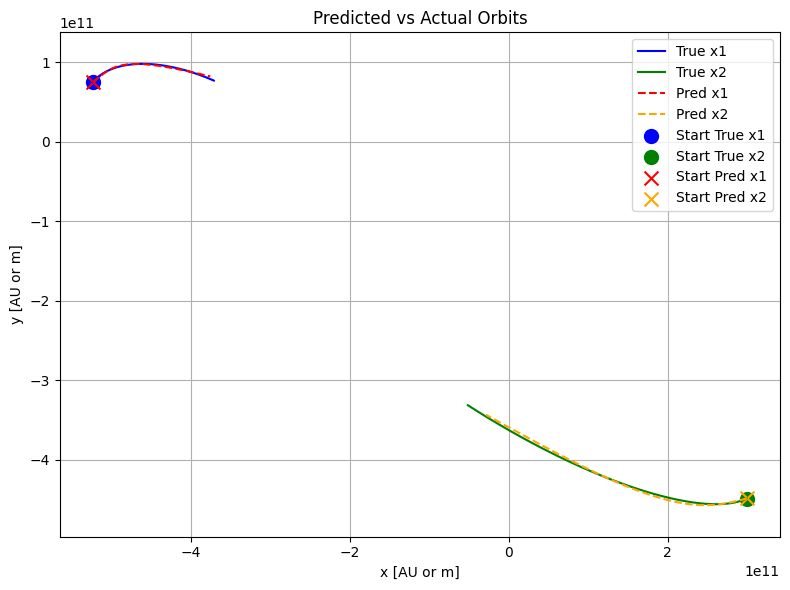

In [22]:
t_test = np.linspace(t_min, t_max, 5000).reshape(-1, 1)
t_test_norm = (t_test - t_min) / (t_max - t_min)

t_tensor = torch.tensor(t_test_norm, dtype=torch.float32, device=device)

model.eval()
with torch.no_grad():
    y_pred_norm = model(t_tensor)
    y_pred = y_pred_norm * (y_max - y_min) + y_min  # unnormalize to physical units
    y_pred = y_pred.cpu().numpy()  # move to CPU for plotting

x1_pred = y_pred[:, 0:2]
x2_pred = y_pred[:, 2:4]

x1_true = Y_data[:, 0:2]
x2_true = Y_data[:, 2:4]

plt.figure(figsize=(8, 6))
plt.plot(x1_true[:, 0], x1_true[:, 1], 'b-', label='True x1')
plt.plot(x2_true[:, 0], x2_true[:, 1], 'g-', label='True x2')

plt.plot(x1_pred[:, 0], x1_pred[:, 1], 'r--', label='Pred x1')
plt.plot(x2_pred[:, 0], x2_pred[:, 1], 'orange', linestyle='--', label='Pred x2')

plt.scatter(x1_true[0, 0], x1_true[0, 1], color='blue', s=100, marker='o', label='Start True x1')
plt.scatter(x2_true[0, 0], x2_true[0, 1], color='green', s=100, marker='o', label='Start True x2')
plt.scatter(x1_pred[0, 0], x1_pred[0, 1], color='red', s=100, marker='x', label='Start Pred x1')
plt.scatter(x2_pred[0, 0], x2_pred[0, 1], color='orange', s=100, marker='x', label='Start Pred x2')

plt.xlabel("x [AU or m]")
plt.ylabel("y [AU or m]")
plt.title("Predicted vs Actual Orbits")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()